In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import pickle  # Pour sauvegarder l'état de PCAx

# Matplotlib settings
from matplotlib import rcParams

# Scikit-learn modules
import pcax 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Keras (deep learning)
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.losses import MeanSquaredError, Huber, MeanAbsoluteError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l1, l2, l1_l2
from pathlib import Path

# again, this only works on startup!
import jax
jax.config.update("jax_enable_x64", True)

2025-03-20 10:29:33.699216: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import pcax  # Assure-toi que pcax est bien importé

# 📌 Chargement des simulations
data_path = Path("/Users/xifumacbook/Documents/Codes/Spectres/apec/apec_simon_approved.npz")  # Modifier selon ton répertoire
data = np.load(data_path)

# Extraction des simulations et des paramètres
spectres = data["simulations"]
theta = data["theta"]

# Suppression des colonnes non nécessaires dans theta (redshift, approx, norm)
theta = np.delete(theta, [1, 2, -1], axis=1)  # Indices à adapter si besoin

# Vérification des dimensions
print(f"Theta shape : {theta.shape}")  # Paramètres
print(f"Spectrum shape : {spectres.shape}")  # Spectres simulés

#spectres = np.random.poisson(lam=np.abs(spectres))

# Transformation log des spectres
spectres = np.log1p(spectres)

# Normalisation sur l'ensemble des données
scaler_theta = RobustScaler()
scaler_spectre = MinMaxScaler()

#theta_scaled = scaler_theta.fit_transform(theta)
theta_scaled = theta
spectres_scaled = scaler_spectre.fit_transform(spectres)

# PCA sur les spectres normalisés
n_PCA = 20
pca_state = pcax.fit(spectres, n_components=n_PCA    )
spectres_pca = pcax.transform(pca_state, spectres)

#spectres_scaled = scaler_spectre.fit_transform(spectres_pca)

# Division des données après transformations
X_train, X_test, y_train, y_test = train_test_split(theta_scaled, spectres_pca, test_size=0.1, random_state=42)

# Vérification post-split
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

# Variance expliquée par la PCA
explained_variance = np.sum(y_train.var(axis=0)) / np.sum(spectres_pca.var(axis=0))
print(f"Variance explained by the {n_PCA} first components : {explained_variance:.4%}")

# Calcul de la variance expliquée par composante
explained_variance_per_component = y_train.var(axis=0) / np.sum(y_train.var(axis=0))
cumulative_variance = np.cumsum(explained_variance_per_component)

# Plot de la variance expliquée
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_per_component) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.99, color='r', linestyle='--', label="99% de variance expliquée")
plt.xlabel("Nombre de PCA")
plt.ylabel("Variance expliquée cumulée")
plt.legend()
plt.show()


Theta shape : (50000, 1)
Spectrum shape : (50000, 10000)
X_train shape: (45000, 1), X_test shape: (5000, 1)
y_train shape: (45000, 20), y_test shape: (5000, 20)


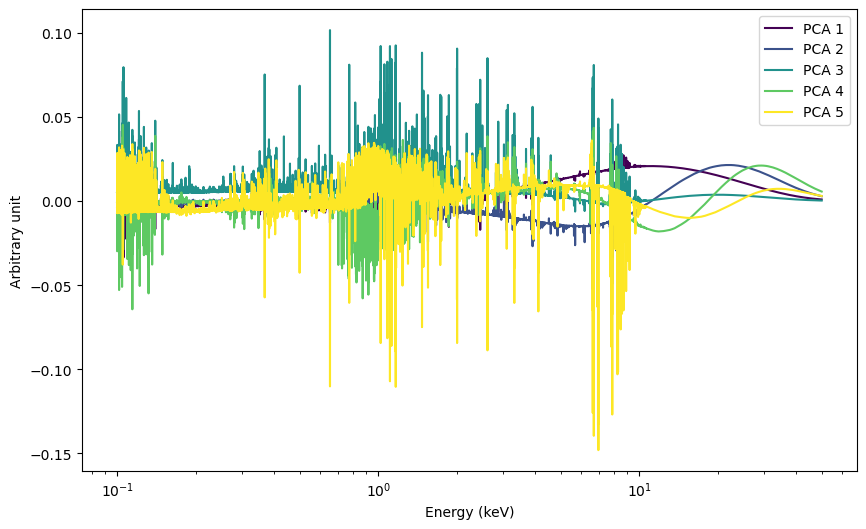

In [ ]:
# Définition de l'échelle d'énergie
e_min, e_max, num_bins = 0.1, 50, spectres.shape[1]  
energy_array = np.geomspace(e_min, e_max, num_bins)

# Récupération des 5 premières composantes PCA
pca_components = pca_state.components[:10, :]



# Tracé des 5 premières composantes en fonction de l'énergie
plt.figure(figsize=(10, 6))

for i in range(5):
    plt.plot(energy_array, pca_components[i], label=f'PCA {i+1}')

plt.xscale('log')
plt.xlabel("Energy (keV)")
plt.ylabel("Arbitrary unit")
plt.legend()
plt.show()


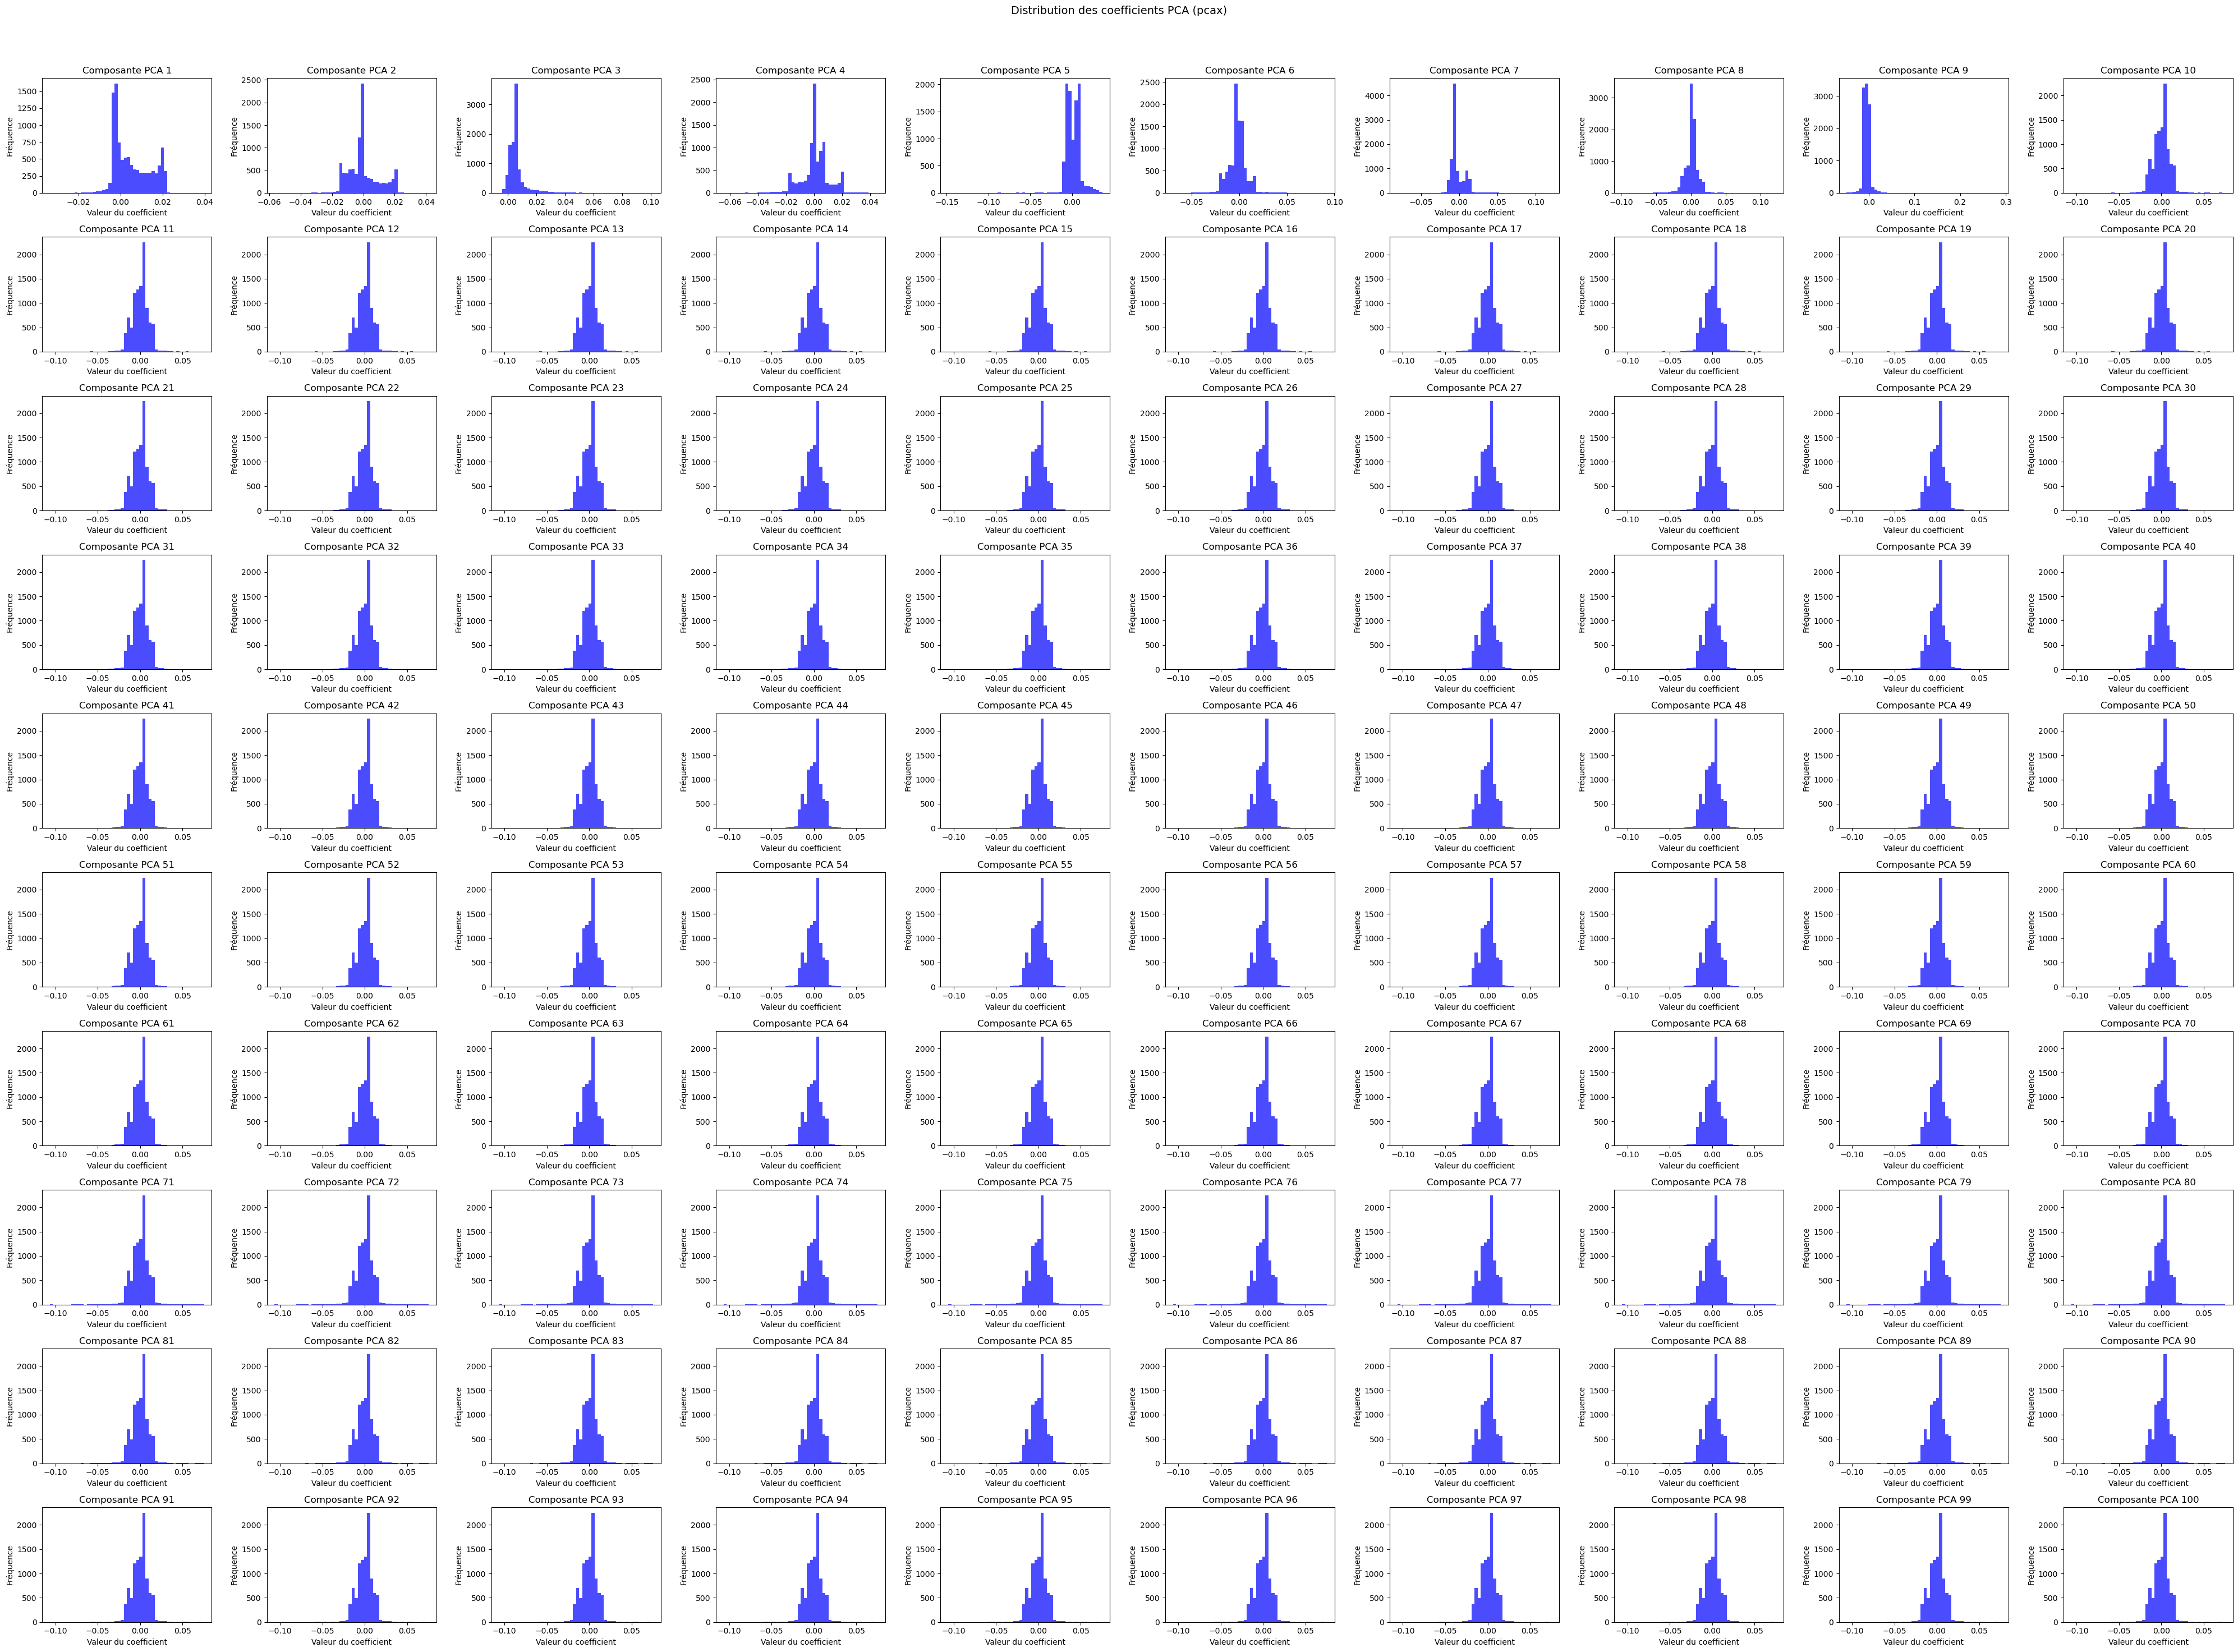

In [ ]:

# Détermination de la grille optimale (rows x cols)
n_rows = int(np.ceil(np.sqrt(n_PCA)))
n_cols = int(np.ceil(n_PCA / n_rows))

# Création des subplots dynamiquement
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 3))
fig.suptitle("Distribution des coefficients PCA (pcax)", fontsize=14)

# S'assurer que axes est toujours un tableau (utile si une seule ligne ou colonne)
axes = np.array(axes).reshape(n_rows, n_cols)

# Affichage des histogrammes
for i in range(n_PCA):
    row, col = divmod(i, n_cols)
    ax = axes[row, col]
    ax.hist(pca_components[i], bins=50, color='blue', alpha=0.7)
    ax.set_title(f"Composante PCA {i+1}")
    ax.set_xlabel("Valeur du coefficient")
    ax.set_ylabel("Fréquence")

# Supprime les axes inutilisés si la grille est plus grande que nécessaire
for i in range(n_PCA, n_rows * n_cols):
    row, col = divmod(i, n_cols)
    fig.delaxes(axes[row, col])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustement du layout
plt.show()


/Users/xifumacbook/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,964 (1.61 MB)

 Trainable params: 420,964 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0384 - val_loss: 0.0022 - learning_rate: 1.0000e-04
Epoch 2/500
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0022 - val_loss: 0.0021 - learning_rate: 1.0000e-04
Epoch 3/500
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0021 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 4/500
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0021 - val_loss: 0.0021 - learning_rate: 1.0000e-04
Epoch 5/500
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0020 - val_loss: 0.0021 - learning_rate: 1.0000e-04
Epoch 6/500
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0021 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 7/500
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0020 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 8/500
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - lo

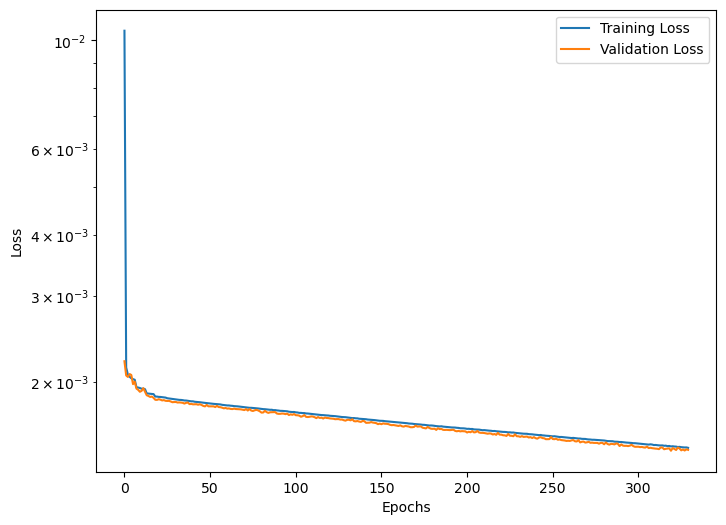

In [ ]:
from keras.losses import LogCosh, Huber
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 📌 **Définition de la fonction de perte combinée**
def combined_loss(y_true, y_pred):
    huber = Huber(delta=5.5)(y_true, y_pred)  # Ajuste delta si besoin
    logcosh = LogCosh()(y_true, y_pred)
    return huber + logcosh  # Addition des pertes

# 📌 **Définition du modèle de réseau de neurones**
def TTNN(input_dim, output_dim, learning_rate=1e-4):
    model = Sequential([
        Dense(256, activation='elu', input_shape=(input_dim,)),
        Dense(256, activation='elu'),
        Dense(256, activation='elu'),
        Dense(256, activation='elu'),
        Dense(256, activation='elu'),
        #Dropout(0.1),
        # Dense(256, activation='elu'),
        # Dense(256, activation='elu'),
        #Dense(256, activation='selu'),
        #Dense(256, activation='selu'),
        #Dense(256, activation='selu'),
        Dense(output_dim, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=LogCosh()
        # Huber(5.5)  # Utilisation de la perte combinée
    )
    
    return model

# 📌 **Détermination des dimensions d'entrée et sortie**
input_dim = X_train.shape[1]    # Dimensions de theta après normalisation
output_dim = y_train.shape[1]   # Nombre de composantes PCA (déjà transformées)

# 📌 **Construction et résumé du modèle**
model = TTNN(input_dim, output_dim)
model.summary()

# 📌 **Définition des callbacks**
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# 📌 **Entraînement du modèle**
history = model.fit(
    X_train, y_train,
    validation_split=0.1,  
    epochs=500,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.show()

plot_loss(history)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 📌 **Reconstruction des spectres**
def reconstruct_spectra(pca_state, scaler_spectre, y_pca):
    y_scaled = pcax.recover(pca_state, y_pca)
    y_log = scaler_spectre.inverse_transform(y_scaled)
    return np.expm1(y_log)  # Conversion inverse du log1p                                     # 🔄 3. Annulation du log1p

# 📌 **Analyse d'un échantillon spécifique**
def plot_sample(idx):
    theta_sample = X_test[idx:idx+1]  # Échantillon unique pour la prédiction

    # 📌 **Prédiction dans l'espace du SCALER**
    spectrum_true_scaled = y_test[idx]                          # `y_test` est déjà SCALÉ
    spectrum_pred_scaled = model.predict(theta_sample)[0]

    # 📌 **Reconstruction complète vers l'espace d'origine**
    spectrum_true_orig = reconstruct_spectra(pca_state, scaler_spectre, spectrum_true_scaled.reshape(1, -1)).flatten()
    spectrum_pred_orig = reconstruct_spectra(pca_state, scaler_spectre, spectrum_pred_scaled.reshape(1, -1)).flatten()

    # 📌 **Calcul de l'erreur relative par bin**
    eps = 1e-8
    error_bin = (spectrum_true_orig - spectrum_pred_orig) / (np.abs(spectrum_true_orig) + eps) * 100
    global_error = 100 * np.linalg.norm(spectrum_true_orig - spectrum_pred_orig) / np.linalg.norm(spectrum_true_orig)

    print(f"Sample {idx} | Relative overall error : {global_error:.3f}%")

    # 📌 **Échelle d'énergie (logarithmique)**
    e_min, e_max, num_bins = 0.1, 50, spectrum_true_orig.shape[0]
    energy_array = np.geomspace(e_min, e_max, num_bins)

    # 📌 **Récupération des paramètres d'entrée**
    theta_orig = X_test[idx]
    param_names = [r"$kT$"]  # Tu adaptes ici si plus de paramètres

    # 📌 **Affichage des paramètres**
    print("Parameters used for the sample:")
    for name, value in zip(param_names, theta_orig):
        print(f" - {name}: {value:.4f}")

    param_str = ", ".join([f"{name}={value:.3f}" for name, value in zip(param_names, theta_orig)])

    # 📌 **Plot des résultats**
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

    ax1.semilogx(energy_array, spectrum_pred_orig, label='Reconstructed spectrum', color='blue')
    ax1.semilogx(energy_array, spectrum_true_orig, label='Original spectrum', color='red', linestyle="dashed")
    ax1.set_ylabel("Intensity")
    ax1.set_xlabel("Energy (keV)")
    ax1.legend()
    ax1.set_title(f"Sample {idx}\n{param_str}", fontsize=10)

    ax2.plot(energy_array, error_bin, label="Relative error (%)", color='red')
    ax2.fill_between(energy_array, 0, error_bin, color='red', alpha=0.3)
    ax2.set_xlabel("Energy (keV)")
    ax2.set_ylabel("Error (%)")
    ax2.legend()

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Sample 89 | Relative overall error : 24.138%
Parameters used for the sample:
 - $kT$: 6.0561


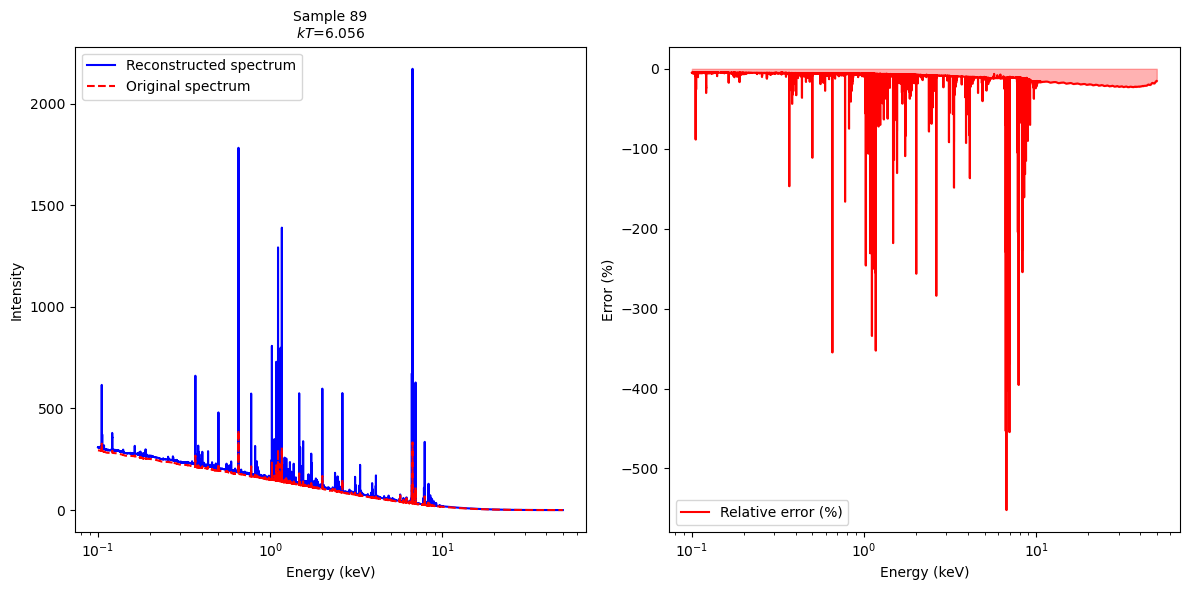

In [ ]:
plot_sample(89)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 📌 **Reconstruction des spectres**
def reconstruct_spectra(pca_state, scaler_spectre, y_pca):
    y_scaled = pcax.recover(pca_state, y_pca)
    y_log = scaler_spectre.inverse_transform(y_scaled)
    return np.expm1(y_log)  # Conversion inverse du log1p

# 📌 **Analyse des erreurs globales sur kT uniquement**
def plot_global_errors_kT(model, X_test, y_test, pca_state, pcax, scaler_spectre):
    """
    Trace les erreurs globales en fonction du seul paramètre kT.
    """
    eps = 1e-8

    # 📌 **Prédictions du modèle**
    y_pred_pca = model.predict(X_test)

    # 📌 **Reconstruction des spectres**
    y_test_orig = reconstruct_spectra(pca_state, scaler_spectre, y_test)
    y_pred_orig = reconstruct_spectra(pca_state, scaler_spectre, y_pred_pca)

    # 📌 **Calcul des erreurs globales**
    global_errors = [
        100 * np.linalg.norm(true_spectrum - pred_spectrum) / (np.linalg.norm(true_spectrum) + eps)
        for true_spectrum, pred_spectrum in zip(y_test_orig, y_pred_orig)
    ]
    global_errors = np.array(global_errors)

    print(f"X_test shape: {X_test.shape}")
    print(f"Global_errors shape: {global_errors.shape}")

    # 📌 **Indices des spectres avec erreur > 3%**
    high_error_indices = np.where(global_errors > 3)[0]
    print(f"\n Nombre de spectres avec une erreur > 1% : {len(high_error_indices)}")
    if len(high_error_indices) > 0:
        print(f"Indices des spectres concernés : {high_error_indices}")

    # 📌 **Récupération de kT uniquement (colonne index 1)**
    kT = X_test[:, 0]

    # 📌 **Plot des erreurs globales en fonction de kT**
    plt.figure(figsize=(6, 5))
    plt.scatter(kT, global_errors, color='dodgerblue', alpha=0.7, edgecolor='black', s=40)
    plt.xlabel(r"$kT$ (keV)")
    plt.ylabel("Global Error (%)")
    plt.tight_layout()
    plt.show()

    return high_error_indices

# 📌 **Exécution uniquement sur kT**
high_error_indices = plot_global_errors_kT(
    model=model,
    X_test=X_test,
    y_test=y_test,
    pca_state=pca_state,
    pcax=pcax,
    scaler_spectre=scaler_spectre
)

print(f"\n Indices des spectres avec erreur > 3% : {high_error_indices}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


ValueError: operands could not be broadcast together with shapes (5000,10000) (100,) (5000,10000) 